In [12]:
import scipy
import numpy as np
import neurodsp
import glob
import matplotlib.pyplot as plt

In [2]:
# minerva_directory = '/sc/arion/scratch/qasims01/misc'
local_directory = '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926'
mat_files = glob.glob(f'{local_directory}/*.mat')

In [3]:
mat_files

['/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0001.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0002.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0003.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0004.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0005.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0006.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0007.mat',
 '/Users/fuq01/Desktop/leap-analysis/LFP/Data_20220926\\LT2D-0.007F0008.mat']

In [51]:
# join all LFP arrays
CLFP_all = np.array([])
for m in mat_files:
    file = scipy.io.loadmat(m)
    CLFP_01 = file['CLFP_01'].flatten()
    CLFP_all = np.concatenate([CLFP_all, CLFP_01], axis=None)
    CLFP_hz = file['CLFP_01_KHz'].flatten()*1000

In [52]:
CLFP_hz

array([1375.])

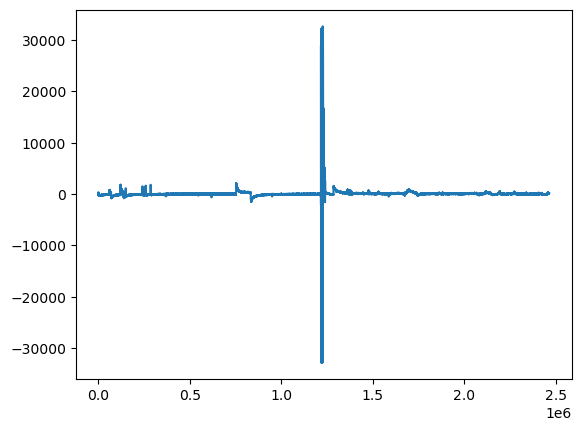

In [53]:
CLFP_all
plt.plot(CLFP_all)

array([[1.375]])

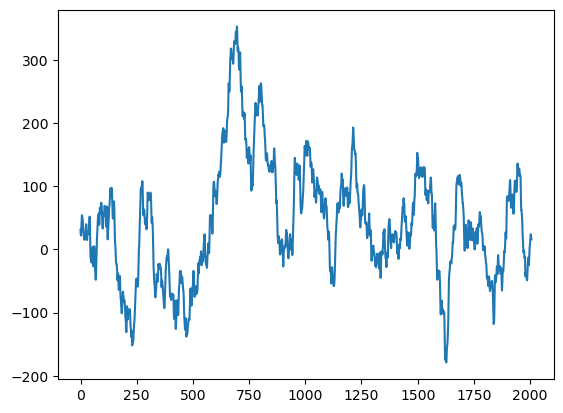

In [47]:
# single file examination
mat_file = scipy.io.loadmat(mat_files[0])
CLFP_01 = mat_file['CLFP_01']
plt.plot(CLFP_01[0,:])
mat_file['CMacro_LFP_01_KHz']

In [32]:
# Load in the relevant neural data 
CMacro_LFP_01 = mat_file['CMacro_LFP_01']
CLFP_01 = mat_file['CLFP_01']

# Pre-processing IIR filtering

In [48]:
# Pre-processing: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/filt/plot_3_IIR.html?highlight=line%20noise
# Import functions for IIR filtering
from neurodsp.filt import filter_signal
from neurodsp.filt.iir import design_iir_filter, apply_iir_filter
from neurodsp.filt.utils import compute_frequency_response, compute_transition_band

# Import plotting functions
from neurodsp.plts import plot_frequency_response, plot_time_series

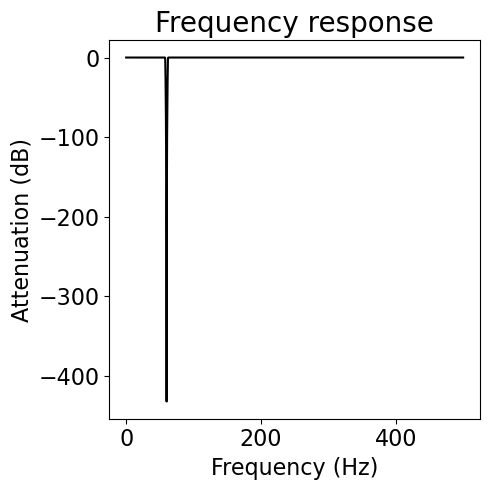

In [54]:
# setting (double check here later)
n_seconds = 1
fs = 1000

# Define filter settings
pass_type = 'bandstop'
f_range = (58, 62) #freq range to filter out
butterworth_order = 12

# Design the filter, getting the second-order series (sos) values for the filter
sos = design_iir_filter(fs, pass_type, f_range, butterworth_order)

# Compute the frequency response for the IIR filter
f_db, db = compute_frequency_response(sos, None, fs)

# Plot the frequency response
plot_frequency_response(f_db, db)

In [7]:
filter_signal?
#bandstop, exclusion
#bandpass, inclusion 

Signature:
filter_signal(
    sig,
    fs,
    pass_type,
    f_range,
    filter_type='fir',
    n_cycles=3,
    n_seconds=None,
    remove_edges=True,
    butterworth_order=None,
    print_transitions=False,
    plot_properties=False,
    return_filter=False,
)
Docstring:
Apply a bandpass, bandstop, highpass, or lowpass filter to a neural signal.

Parameters
----------
sig : 1d or 2d array
    Time series to be filtered.
fs : float
    Sampling rate, in Hz.
pass_type : {'bandpass', 'bandstop', 'lowpass', 'highpass'}
    Which kind of filter to apply:

    * 'bandpass': apply a bandpass filter
    * 'bandstop': apply a bandstop (notch) filter
    * 'lowpass': apply a lowpass filter
    * 'highpass' : apply a highpass filter
f_range : tuple of (float, float) or float
    Cutoff frequency(ies) used for filter, specified as f_lo & f_hi.
    For 'bandpass' & 'bandstop', must be a tuple.
    For 'lowpass' or 'highpass', can be a float that specifies pass frequency, or can be
    a tuple an

c:\Users\fuq01\Anaconda3\envs\LFPAnalysis\Lib\site-packages\neurodsp\filt\filter.py:98: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')


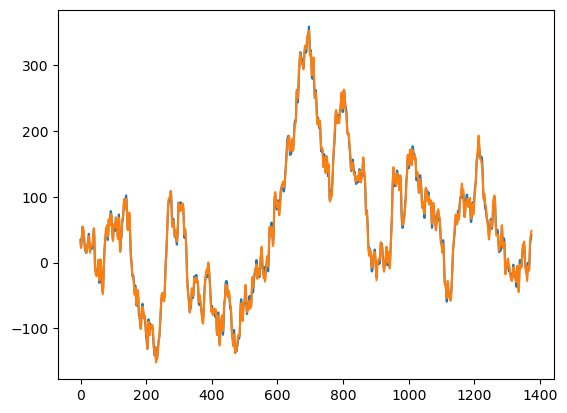

In [90]:
#filtering test
f_range = (58, 62)
sig_filt = filter_signal(CLFP_all, CLFP_hz, 'bandstop', f_range,
                         filter_type='iir', butterworth_order=3)

# Plot filtered signal for the first 1 second
plt.plot(sig_filt[0:1375]) #filtered
plt.plot(CLFP_all[0:1375]) #raw

# Power spectral
There seems to be a harware filter at 60 hz, no peak signal at 60 hz from the power spectral graph.

Need to ask all the hardware filter that has been applied to the raw data. 

In [92]:
# Import spectral power functions
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

In [61]:
# Mean of spectrogram (Welch)
freq_mean, psd_mean = compute_spectrum(CLFP_all, CLFP_hz, method='welch', avg_type='mean', nperseg=fs*2)

# Median of spectrogram ("median Welch")
freq_med, psd_med = compute_spectrum(CLFP_all, CLFP_hz, method='welch', avg_type='median', nperseg=fs*2)

# Median filtered spectrum
freq_mf, psd_mf = compute_spectrum(CLFP_all, CLFP_hz, method='medfilt')

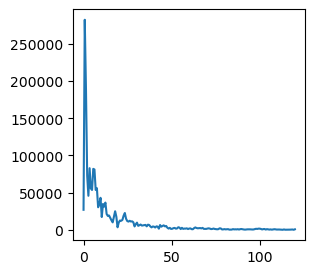

In [89]:
f, ax = plt.subplots(1,1, figsize=(3,3))
new_freqs = freq_mean[freq_mean<120] #subset the frequency range (sample rate double down)
new_psd = psd_mean[freq_mean<120]
ax.plot(new_freqs, new_psd)

# ax.set_xticklabels(np.round(new_freqs[np.linspace(0, len(new_freqs)-1, 6).astype(int)]))
# can also log the freq_mean if keep it all

In [91]:
np.round(freq_mean[np.linspace(0, len(freq_mean)-1, 6).astype(int)])

array([  0., 138., 275., 413., 550., 688.])

# Analysis

In [26]:
# Analysis: https://neurodsp-tools.github.io/neurodsp/

# Compute PSD https://neurodsp-tools.github.io/neurodsp/auto_tutorials/spectral/plot_SpectralPower.html#sphx-glr-auto-tutorials-spectral-plot-spectralpower-py

# time-frequency spectrograms: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html#sphx-glr-auto-tutorials-timefreq-plot-morletwavelet-py



# FOOF pipeline 

pre-post 1 minute power curve


In [ ]:
# EVENTUALLY: Load in the behavioral data and synchronize it to the neural 